In [2]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [3]:
file_name = "PrepaidTravelCost"
attribute_key = "RequestedAmount"

In [4]:
case_attribute_key = f'case:{attribute_key}'
case_id_key = "case:concept:name"

# df = pm4py.read_xes(f'../logs/{file_name}.xes')
df = pd.read_csv(f'../logs/{file_name}.{attribute_key}.csv')
df["time:timestamp"] = pd.to_datetime(df['time:timestamp'])

df = df.dropna(subset=[case_attribute_key]).reset_index() # filter empty rows

In [5]:
def Gini(l, m):
    n1 = len(l)
    n2 = len(m)
    n = n1 + n2
    return (n1/n) * (1 - sum([ pr**2 for pr in l.values() ])) + (n2/n) * (1 - sum([ pr**2 for pr in m.values() ]))

In [6]:
attribute_values = pm4py.get_trace_attribute_values(df, attribute_key)
sorted_attribute_values = sorted([ float(k) for k in attribute_values.keys() ])

# group df by case ids
grouped = df.filter([case_id_key, case_attribute_key]).groupby(case_id_key, sort=False)

In [7]:
import numpy as np

df_gte_light = grouped.first() # initial gte group

# define absolute languages (counting the occurrence of cases)
# devide absoulte numbers by total number of cases later(!), otherwise every values has to be updated
language_lt = {}
language_gte = pm4py.stats.get_variants(df)

ginis = []
g1s = []
g2s = []
n1s = []
n2s = []

t = time.time()

for pivot in tqdm(sorted_attribute_values[1:]):

    # find affected cases
    df_affected_light_idx = df_gte_light[df_gte_light[case_attribute_key].values < pivot].index

    # remove affected cases from gte group
    df_gte_light.drop(df_affected_light_idx, inplace=True)

    # translate into full df
    df_affected = pd.concat([ df.loc[grouped.indices[i]] for i in df_affected_light_idx ])

    # update absoulte languages
    for tr, n in pm4py.stats.get_variants(df_affected).items():
        language_lt[tr] = language_lt.setdefault(tr, 0) + n
        language_gte[tr] = language_gte[tr] - n

    language_lt_size = sum(language_lt.values(), 0.0)
    language_gte_size = sum(language_gte.values(), 0.0)

    stochastic_language_lt = { k: v / language_lt_size for k, v in language_lt.items() }
    stochastic_language_gte = { k: v / language_gte_size for k, v in language_gte.items() }

    n1 = language_lt_size
    n2 = language_gte_size
    n = n1 + n2
    g1 = (1 - sum([ pr**2 for pr in stochastic_language_lt.values() ])) 
    g2 = (1 - sum([ pr**2 for pr in stochastic_language_gte.values() ]))
    gini = (n1/n) * g1 + (n2/n) * g2

    # collect data to plot graph
    ginis.append(gini)
    n1s.append(n1/n)
    n2s.append(n2/n)
    g1s.append(g1)
    g2s.append(g2)

t = time.time() - t

time.sleep(1)

print(f"time elapsed: {t}")

100%|██████████| 2048/2048 [00:02<00:00, 804.18it/s]


time elapsed: 2.551697015762329


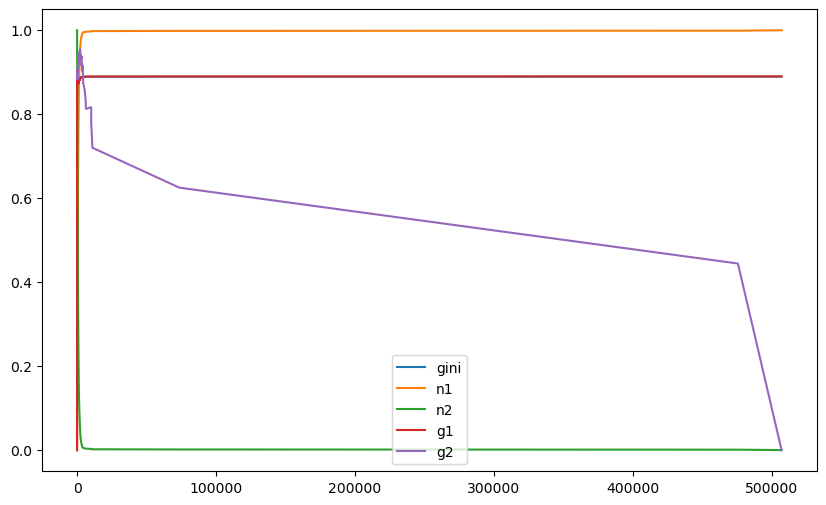

In [8]:
plt.figure(figsize=(10,6))

# plot mmlngld
plt.plot(sorted_attribute_values[1:], ginis, label="gini")

plt.plot(sorted_attribute_values[1:], n1s, label="n1")
plt.plot(sorted_attribute_values[1:], n2s, label="n2")
plt.plot(sorted_attribute_values[1:], g1s, label="g1")
plt.plot(sorted_attribute_values[1:], g2s, label="g2")

plt.legend()
plt.savefig(f"out.gini.{file_name}.{attribute_key}.png", bbox_inches="tight")

In [9]:
pd.DataFrame({"n1": n1s, "n2": n2s, "g1": g1s, "g2": g2s, "gini": ginis}).to_csv(f"out.gini.{file_name}.{attribute_key}.csv", index=False, header=False)